In this assignment, we'll explore a more advanced use of deep learning on a
natural language process (NLP) task involving news headlines. 
In particular, we'll be working with a dataset of Reuters news headlines
collected over a span of 15 months, covering some of 2018, 2019, and early 2020.
This assignment will combine several of the concepts that we discussed in class,
including recurrent neural networks, data augmentation, autoencoders (soon), 
and working with embeddings.

To be more specific, we'll be building an **autoencoder** of news headlines.
We will build an **encoder** model that maps a news headline to a vector embedding,
and a **decoder** that reconstructs the news headline. By building a model that
learns to reconstruct the news headlines from the vector embedding, the model
will learn good embeddings of these headlins.

We'll see a similar idea with image autoencoders and image VAEs, but
both our encoder and decoder networks will be Recurrent Neural Networks.
You'll have a chance build networks that takes a sequence as an input,
and a network that generates a sequence as an output.

This project is organized as follows:

- Part 1. Data exploration
- Part 2. Background Math
- Part 3. Building the autoencoder
- Part 4. Training the autoencoder using *data augmentation*
- Part 5. Analyzing the embeddings (interpolating between headlines)

Much of the idea behind this assignment is movtivated by Shen et al [1].
We'll use the data augmentation rules proposed in that work to improve
the robustness of the autoencoder.

[1] Shen et al (2019) "Educating Text Autoencoders: Latent Representation Guidance via Denoising" https://arxiv.org/pdf/1905.12777.pdf

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import random

%matplotlib inline

## Part 1

Download the files `reuters_train.txt` and `reuters_valid.txt`, and upload them to Google Drive.

Then, mount Google Drive from your Google Colab notebook:

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
train_path = '/content/gdrive/My Drive/reuters_train.txt' 
valid_path = '/content/gdrive/My Drive/reuters_valid.txt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


We will be using PyTorch's `torchtext` utilities to help us load, process,
and batch the data. This package is useful, but takes a bit of time to get
used to. 

We'll be using a `TabularDataset` to load our data, which works well on structured
CSV data with fixed columns (e.g. a column for the sequence, a column for the label). Our tabular dataset
is even simpler: we have no labels, just some text. So, we are treating our data as a table with one field
representing our sequence.

In [ ]:
import torchtext.legacy as torchtext
# Tokenization function to separate a headline into words
def tokenize_headline(headline):
    """Returns the sequence of words in the string headline. We also
    prepend the "<bos>" or beginning-of-string token, and append the
    "<eos>" or end-of-string token to the headline.
    """
    return ("<bos> " + headline + " <eos>").split()
    
# Data field (column) representing our *text*.
text_field = torchtext.data.Field(
    sequential=True,            # this field consists of a sequence
    tokenize=tokenize_headline, # how to split sequences into words
    include_lengths=True,       # to track the length of sequences, for batching
    batch_first=True,      # similar to batch_first=True in nn.RNN demonstrated in lecture
    use_vocab=True)             # to turn each character into an integer index
train_data = torchtext.data.TabularDataset(
    path=train_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

Draw histograms of the number of words per headline in our training set.
Excluding the `<bos>` and `<eos>` tags in your computation.
Explain why we would be interested in such histograms.

(171443,)


(array([4.0900e+02, 9.0940e+03, 6.1255e+04, 5.6220e+04, 3.8670e+04,
        5.4620e+03, 3.0400e+02, 2.3000e+01, 5.0000e+00, 1.0000e+00]),
 array([ 2. ,  4.7,  7.4, 10.1, 12.8, 15.5, 18.2, 20.9, 23.6, 26.3, 29. ]),
 <a list of 10 Patch objects>)

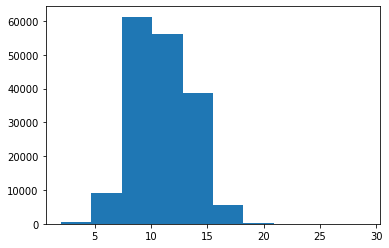

In [ ]:
histogram_data = []
for article in train_data:
  histogram_data.append(len(article.title))
number_per_headline = np.array(histogram_data) - 2
total_words = np.sum(number_per_headline) # Total words in all headlines used in 1(d)

print(number_per_headline.shape)
plt.hist(number_per_headline)
# Number of words per headline effects the attention aspect of the RNN. More words mean 
# more weights will be included in between layers. We are interested to know about these
# to optimize our model better.

Exclude the `<bos>` and `<eos>` tags in your computation.

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# You might find the python class Counter from the collections package useful
from collections import Counter
all_words = []

for article in train_data:
  for words in article.title:
    if words != '<bos>' and words != '<eos>':
      all_words.append(words)

counter_words = Counter(all_words)
print("Number of distinct words:")
print(len(counter_words))

Number of distinct words:
51298


The distribution of *words* will have a long tail, meaning that there are some words
that will appear very often, and many words that will appear infrequently.

In [ ]:
count_1 = 0
count_2 = 0
for frequency in counter_words.values():
  if frequency == 1:
    count_1 += 1
  if frequency == 2:
    count_2 += 1

print("Exactly once:")
print(count_1)
print("Exactly twice:")
print(count_2)

Exactly once:
19854
Exactly twice:
7193


In [ ]:
# There are few reasons:
# 1) It is faster to train if our model works with less words
# 2) There will always be rare words or even mistyped words that is not in our vocabulary,
# our model should be able to make predictions without knowing every single word.
# 3) Knowing every single word in our training data could overfit the model to it, model
# would start predicting wrong when dealing with words outside of the training data.

We will only model the top 9995 words in the training set, excluding the tags
`<bos>`, `<eos>`, and other possible tags we haven't mentioned yet
(including those, we will have a vocabulary size of exactly 10000 tokens).

In [ ]:
supported_occurences = 0
counter = 0
for keys in counter_words.keys():
  supported_occurences += counter_words[keys]
  counter += 1
  if counter == 9995:
    break

sup = supported_occurences/total_words
not_sup = 1 - sup
print("Percentage of supported words:")
print(sup)
print("Percentage of `<unk>` tag words:")
print(not_sup)

Percentage of supported words:
0.890645389865422
Percentage of `<unk>` tag words:
0.10935461013457803


Our `torchtext` package will help us keep track of our list of unique words, known
as a **vocabulary**. A vocabulary also assigns a unique integer index to each word.
You can interpret these indices as sparse representations of one-hot vectors.

In [ ]:
# Build the vocabulary based on the training data. The vocabulary
# can have at most 9997 words (9995 words + the <bos> and <eos> token)
text_field.build_vocab(train_data, max_size=9997)

# This vocabulary object will be helpful for us
vocab = text_field.vocab
print(vocab.stoi["hello"]) # for instances, we can convert from string to (unique) index
print(vocab.itos[10])      # ... and from word index to string

# The size of our vocabulary is actually 10000
vocab_size = len(text_field.vocab.stoi)
print(vocab_size) # should be 10000

# The reason is that torchtext adds two more tokens for us:
print(vocab.itos[0]) # <unk> represents an unknown word not in our vocabulary
print(vocab.itos[1]) # <pad> will be used to pad short sequences for batching

0
on
10000
<unk>
<pad>


Choosing the right model architecture is key for any successful deep learning system.
In this question, we will compare the learning performance of RNNs and GRUs from the perspective
of the vanishing/exploding gradient problem that arises during backpropagation.

First, we will analyze the recurrent weight matrix of an RNN using Singular Value Decomposition (SVD). SVD says that that any real matrix $M \in \mathbb{R}^{m \times n}$ can be written as $W = U \Sigma V^T$ where $U \in \mathbb{R}^{m \times m}$ and $V \in \mathbb{R}^{n \times n}$ are square orthogonal matrices, and $\Sigma \in \mathbb{R}^{m \times n}$ is a rectangular diagonal matrix. Recall that the values of $\Sigma$ are the *eigenvalues* of $M$.o

(For a quick overview of eigenvalues and eigenvectors, see https://www.youtube.com/watch?v=PFDu9oVAE-g 0:44-5:22 and 13:05-end. The last section
explains visually why we are interested in working with eigenvalues when working with an RNN)

Consider a simple simple RNN-like architecture that computes $x_{t+1} = sigmoid(W x_t)$. You can
view this architecture as a deep fully connected network that uses the same weight matrix at each
layer. Suppose the largest singular value of the weight matrix is $\sigma_{max}(W) = \frac{1}{2}$. 

Show that the largest singular value of the input-output Jacobian has the following bound: $0 \leq \sigma_{max}(\frac{\partial x_n}{\partial x_1}) \leq (\frac{1}{2})^n$. $\textit{Hint}$: if $C = AB$, then $\sigma_{max}(C) \le \sigma_{max}(A) \sigma_{max}(B)$. Also, the input-output Jacobian is the multiplication of layerwise Jacobians).

What does this tell us about the input-output Jacobian $\frac{\partial x_n}{\partial x_1}$ as $n \rightarrow \infty$ ?

\begin{align*}
{P}({n}) &: 0 \leq \sigma_{max}(\frac{\partial x_n}{\partial x_1}) \leq (\frac{1}{2})^n \\
\text{Base case} &: \text{$n=1$ $x_1=x_{0+1}$} = \sigma(Wx_0)  \\
\frac{\partial x_1}{\partial x_1} &= 1\\
\text{Which clearly fails}
\\
\text{$n=2$ $x_2=x_{1+1}$} = \sigma(Wx_1)  \\
\frac{\partial x_2}{\partial x_1} &= \frac{\partial }{\partial x_1} (\sigma(Wx_1))\\
&= W\sigma'(x_1)\\
\text{We know that} &: \sigma_{max}(W)=\frac{1}{2} \text{ and } \sigma_{max}(\sigma'(x_1))
\end{align*}
\begin{align*}
=\frac{1}{4}\\ \because \text{Maximmum of derivative of sigmoid is 0.25 as proven in previous assignments.}
\end{align*}

\begin{align*}
\text{Hence } \sigma_{max}(W\sigma'(x_1)) &=  \sigma_{max}(W)\sigma_{max}(\sigma'(x_1))\\
&= \frac{1}{2} a\\
\text{Where}, 0 \leq &a \leq \frac{1}{4}\\
&\therefore 0 \leq \sigma_{max}(\frac{\partial x_2}{\partial x_1}) \leq (\frac{1}{2})^2 : \text{ is True}\\
\end{align*}

\begin{align*}
\text{Induction hypothesis} &: \text{Assume the following holds all} \\
k &< n \\
\text{i.e } 0 &\leq \sigma_{max}(\frac{\partial x_k}{\partial x_1}) \leq (\frac{1}{2})^k \\
\end{align*}

\begin{align*}
\text{Induction step} &: \text{for $k+1$} \\
\sigma_{max}(\frac{\partial x_{k+1}}{\partial x_1}) &= \sigma_{max}((\frac{\partial x_{k+1}}{\partial x_k})(\frac{\partial x_{k}}{\partial x_1})) \because \text{Chain rule} \\
&= \sigma_{max}(\frac{\partial x_{k+1}}{\partial x_k})\sigma_{max}(\frac{\partial x_{k}}{\partial x_1}) \\
&= \sigma_{max}(\frac{\partial \sigma(Wx_n)}{\partial x_n})b \text{ where $b \leq (\frac{1}{2})^k$, induction hypothesis} \\
&= \sigma_{max}(W\sigma'(x_n))b \\
&= \sigma_{max}(W)\sigma_{max}(\sigma'(x_n))b \\
&= \frac{1}{2} c b , \text{where }  0 \leq c \leq \frac{1}{4} \\
&= \frac{1}{2} c b \leq (\frac{1}{2})^{k+1} 
\\
\text{Hence} &: 0 \leq \sigma_{max}(\frac{\partial x_{k+1}}{\partial x_1}) \leq(\frac{1}{2})^{k+1} \\
\text{Base case 2 is true. } & \text{ $P(k)$ is true then $P(k+1)$ is true} \\
&\therefore \text{From mathematical induction $P(n)$ is true.} \\
\text{Hence} &: 0 \leq \sigma_{max}(\frac{\partial x_n}{\partial x_1}) \leq(\frac{1}{2})^{n}, 2 \geq n\\
\text{Given} &, 0 \leq \sigma_{max}(\frac{\partial x_n}{\partial x_1}) \leq(\frac{1}{2})^{n}\\
\text{then} &: \lim_{n\to\infty} 0 \leq \lim_{n\to\infty}\sigma_{max}(\frac{\partial x_n}{\partial x_1}) \leq \lim_{n\to\infty} (\frac{1}{2})^{n}\\
&=  0 \leq \lim_{n\to\infty}(\frac{\partial x_n}{\partial x_1}) \leq 0\\
&=> \lim_{n\to\infty}(\frac{\partial x_n}{\partial x_1}) = 0\\
&\therefore \text{The value would be 0 and the gradient would vanish.}\\
\end{align*}

We will now compare the gradients of a vanilla RNN unit and a Gated Recurrent Unit (GRU).
For both parts (b) and (c), assume that all weights are scalars, and that we have
an input sequence of length $T$ with $x_1 = 1$ and $x_t = 0$ for all other $t$.
Also, assume that $h_0 = 0$ and that after $T$ timesteps, we calculate the squared
loss $L = \frac{1}{2}(y_T - o_T)^2$ where $o_T$ is the target at timestep $T$.

Consider the vanilla RNN units that compute $h_t$ at each timestep $t$ as follows:

$$m_t = W_x x_t + W_h h_{t-1}$$
$$h_t = \tanh(m_t)$$
$$y_t = W_y h_t$$


Compute $\frac{\partial L}{\partial W_x}$ using backpropagation. You should obtain an expression
in terms of the quantities given (like $o_T$, $y_T$, etc...)

Do you see a vanishing gradient problem? What about exploding gradient? Explain.

$$\frac{\partial L}{\partial y_T} = y_T - o_T$$
$$\frac{\partial y_T}{\partial h_T} = W_y$$
$$ \frac{\partial h_T}{\partial m_T} = sech^2(m_T)$$
Note that for $m_T$ we can expand it to a recursively instead of using chainrule, $$m_T = W_x x_T + W_h h_{T - 1} = W_x x_T + W_h(tanh(m_{T-1}))$$
Eventually, $$m_T = W_x x_T + W_h h_{T - 1} = W_h(tanh(...tanh(W_x)) \because x_t = 0, x_1 = 1$$
$$\frac{\partial m_T}{\partial W_x} = W_h (sech^2(W_x)sech^2(tanh(W_x))sech^2$$
$$*(tanh(tanh(W_x)))...sech^2(...(...(tanh(W_x))...)...)$$
$$\frac{\partial L}{\partial W_x =} = (y_T - o_t)(W_y)(sech^2(m_T))(W_h(sech^2(W_x)sech^2$$
$$*(tanh(W_x)...sech^2(...(...(tanh(W_x))...)...)$$

Notice for the final term in the derivative the maximum value of it depends is 
1 (Look at graph in appendix) which occurs at 0. Hence as $W_x$
tends to increase the gradient for it will aproach 0 and vanish. 

Now, let's consider GRU units that uses a gating mechanism, and computes
$h_t$ at each timestep $t$ as follows:

$$z_t = \sigma(W_x x_t + U_z h_{t-1})$$
$$r_t = \sigma(W_r x_t + U_r h_{t-1})$$
$$\hat{h}_t = \tanh(W_h x_t + U_h r_t h_{t-1})$$
$$h_t = (1 - z_t) h_{t-1} + z_t \hat{h}_t$$
$$y_t = W_y h_t$$

Where $\sigma$ is the sigmoid function.

Compute $\frac{\partial L}{\partial W_x}$ using backpropagation.

Can the vanishing gradient problem be prevented? *Hint* : Consider the term $\frac{\partial h_t}{\partial h_{t-1}}$, what role does $z_t$ play in this gradient? Can it help alleviate the vanishing gradient problem?

$$\frac{\partial L}{\partial y_T} = y_T - o_T$$
$$\frac{\partial y_T}{\partial h_T} = W_y$$
$$\frac{\partial h_T}{\partial {z_T}} = h_{T-1} + \hat{h_T}$$
$$\frac{\partial z_T}{\partial W_x} = \sigma'(W_xx_T + U_zh_{T-1})$$
$$\Sigma_{i=1}^T\frac{\partial h_T}{\partial {h_{T-i}}} = \Sigma_{i=1}^T\Pi_{j=T-i}^{T}( 1- z_j + (U_hr_j)(sech^2(U_hr_jh_{j-1})))$$
$$\frac{\partial h_1}{\partial z_1} = \hat{h_1} = tanh(W_h)$$
$$\frac{\partial z_1}{\partial W_x} = \sigma'(Wx)$$
$$\frac{\partial L}{\partial W_x} = (y_T - o_T)(W_y)(h_{T-1} + \hat{h_T}) ((\sigma'(W_xx_T + U_zh_{T-1}))$$
$$ +\Sigma_{i=1}^T\Pi_{j=T-i}^{T}( 1- z_j + (U_hr_j)(sech^2(U_hr_jh_{j-1}))) (tanh(W_h)))$$

It prevents the gradient from vanishing because it shuts off the gate when it is 1. 

**Graph for $sech^2$**

![](https://drive.google.com/uc?export=view&id=1y7xLSx9A_fE2pAbquK8qMeOj_OG1MJRa)  


Building a text autoencoder is a little more complicated than an image autoencoder, so
we'll need to thoroughly understand the model that we want to build before actually building
our model. Note that the best and fastest way to complete this assignment is to spend a *lot*
of time upfront understanding the architecture. The explanations are quite dense, and you
might need to stop every sentence or two to understand what's going on.
You won't feel productive for a while since you won't be writing code,
but this initial investment will help you become more productive later on.
Understanding this architecture will also help you understand other machine learning
papers you might come across. So, take a deep breath, and let's do this!

Here is a diagram showing our desired architecture:

![](p4model.png){ width=90% }

<img src="p4model.png" width="95%" />

There are two main components to the model: the **encoder** and the **decoder**.
As always with neural networks, we'll first describe how to make
**predictions** with of these components. Let's get started:

The **encoder** will take a sequence of words (a headline) as *input*, and produce an
embedding (a vector) that represents the entire headline. In the diagram above,
the vector ${\bf h}^{(7)}$ is the vector embedding containing information about 
the entire headline.  This portion is very similar
to the sentiment analysis RNN that we discussed in lecture (but without the fully-connected
layer that makes a prediction).

The **decoder** will take an embedding (in the diagram, the vector ${\bf h}^{(7)}$) as input,
and uses a separate RNN to **generate a sequence of words**. To generate a sequence of words,
the decoder needs to do the following:

1) Determine the previous word that was generated. This previous word will act as ${\bf x}^{(t)}$
   to our RNN, and will be used to update the hidden state ${\bf m}^{(t)}$. Since each of our
   sequences begin with the `<bos>` token, we'll set ${\bf x}^{(1)}$ to be the `<bos>` token.
2) Compute the updates to the hidden state ${\bf m}^{(t)}$ based on the previous hidden state
   ${\bf m}^{(t-1)}$ and ${\bf x}^{(t)}$. Intuitively, this hidden state vector ${\bf m}^{(t)}$
   is a representation of *all the words we still need to generate*.
3) We'll use a fully-connected layer to take a hidden state ${\bf m}^{(t)}$, and determine
   *what the next word should be*. This fully-connected layer solves a *classification problem*,
   since we are trying to choose a word out of $K=10000$ distinct words. As in a classification
   problem, the fully-connected neural network will compute a *probability distribution* over
   these 10,000 words. In the diagram, we are using ${\bf z}^{(t)}$ to represent the logits,
   or the pre-softmax activation values representing the probability distribution.
4) We will need to *sample* an actual word from this probability distribution ${\bf z}^{(t)}$.
   We can do this in a number of ways, which we'll discuss in question 4. For now, you can 
   imagine your favourite way of picking a word given a distribution over words.
5) This word we choose will become the next input ${\bf x}^{(t+1)}$ to our RNN, which is used
   to update our hidden state ${\bf m}^{(t+1)}$---i.e. to determine what are the remaining
   words to be generated.

We can repeat this process until we see an `<eos>` token generated, or until the generated
sequence becomes too long.

Unfortunately, we can't *train* this autoencoder in the way we just described. That is,
we can't just compare our generated sequence with our ground-truth sequence, and get
gradients. Both sequences are **discrete** entities, so we won't be able to compute
gradients at all! In particular, **sampling is a discrete process**, and so we won't be
able to back-propagate through any kind of sampling that we do.

You might wonder whether we can get away with computing gradients by comparing the
distributions ${\bf z}^{(t)}$ with the ground truth words at each time step. Like any
multi-class classification problem, we can represent the ground-truth words as a one-hot
vector, and use the cross-entropy loss.

In theory, we can do this. In practice, there are a few issues. One is that the generated
sequence might be longer or shorter than the actual sequence, meaning that there may
be more/fewer ${\bf z}^{(t)}$s than ground-truth words. Another more insidious issue
is that the **gradients will become very high-variance and unstable**, because
**early mistakes will easily throw the model off-track**. Early in training,
our model is unlikely to produce the right answer in step $t=1$, so the gradients
we obtain based on the other time steps will not be very useful.

At this point, you might have some ideas about "hacks" we can use to make training
work. Fortunately, there is one very well-established solution called
**teacher forcing** which we can use for training:
instead of *sampling* the next word based on ${\bf z}^{(t)}$, we will forgo sampling,
and use the **ground truth** ${\bf x}^{(t)}$ in the next step.

Here is a diagram showing how we can use **teacher forcing** to train our model:

![](p4model_tf.png){ width=90% }

<img src="p4model_tf.png" width="95%" />

We will use the RNN generator to compute the logits
${\bf z}^{(1)},{\bf z}^{(2)},  \cdots {\bf z}^{(T)}$. These distributions
can be compared to the ground-truth words using the cross-entropy loss.
The loss function for this model will be the sum of the losses across each $t$.
(This is similar to what we did in a pixel-wise prediction problem.)

We'll train the encoder and decoder model simultaneously. There are several components
to our model that contain tunable weights:

- The word embedding that maps a word to a vector representation.
  In theory, we could use GloVe embeddings, or initialize our parameters to
  GloVe embeddings. To prevent students who don't have Colab access
  from having to download a 1GB file, we won't do that.
  The word embedding component is represented with blue arrows in the diagram.
- The encoder RNN (which will use Gated Recurrent Units) that computes the
  embedding over the entire headline. The encoder RNN 
  is represented with black arrows in the diagram.
- The decoder RNN (which will also use Gated Recurrent Units) that computes
  hidden states, which are vectors representing what words are to be generated.
  The decoder RNN is represented with gray arrows in the diagram.
- The **projection MLP** (one fully-connected layer) that computes
  a distribution over the next word to generate, given a decoder RNN hidden
  state.

In [ ]:
class AutoEncoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        """
        A text autoencoder. The parameters 
            - vocab_size: number of unique words/tokens in the vocabulary
            - emb_size: size of the word embeddings $x^{(t)}$
            - hidden_size: size of the hidden states in both the
                           encoder RNN ($h^{(t)}$) and the
                           decoder RNN ($m^{(t)}$)
        """
        super().__init__()
        self.embed = nn.Embedding(num_embeddings=vocab_size, 
                                  embedding_dim=emb_size)  
        self.encoder_rnn = nn.GRU(input_size=emb_size,
                                  hidden_size=hidden_size,
                                  batch_first=True)
        
        #self.decoder_rnn = nn.GRU(input_size=emb_size, 
        #                          hidden_size=hidden_size,
        #                          batch_first=True)
        #self.proj = nn.Linear(in_features=hidden_size,
        #                      out_features=vocab_size) 
        
        self.decoder_rnn = nn.GRU(input_size=hidden_size, 
                                  hidden_size=emb_size, 
                                  batch_first=True)
        self.proj = nn.Linear(in_features=emb_size, 
                              out_features=vocab_size) 

                              

    def encode(self, inp):
        """
        Computes the encoder output given a sequence of words.
        """
        emb = self.embed(inp)
        out, last_hidden = self.encoder_rnn(emb)
        return last_hidden

    def decode(self, inp, hidden=None):
        """
        Computes the decoder output given a sequence of words, and
        (optionally) an initial hidden state.
        """
        emb = self.embed(inp)
        out, last_hidden = self.decoder_rnn(emb, hidden)
        out_seq = self.proj(out)
        return out_seq, last_hidden

    def forward(self, inp):
        """
        Compute both the encoder and decoder forward pass
        given an integer input sequence inp with shape [batch_size, seq_length],
        with inp[a,b] representing the (index in our vocabulary of) the b-th word
        of the a-th training example.

        This function should return the logits $z^{(t)}$ in a tensor of shape
        [batch_size, seq_length - 1, vocab_size], computed using *teaching forcing*.

        The (seq_length - 1) part is not a typo. If you don't understand why
        we need to subtract 1, refer to the teacher-forcing diagram above.
        """
        
        input = inp[:,:-1]
        target = inp[:,1:] 

        hidden = self.encode(input)
        output, hidden = self.decode(target, hidden)
        return output, hidden

To check that your model is set up correctly, we'll train our AutoEncoder
neural network for at least 300 iterations to memorize this sequence:

In [ ]:

headline = train_data[42].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)


We are looking for the way that you set up your loss function
corresponding to the figure above.
**Be very careful of off-by-ones.**

Note that the Cross Entropy Loss expects a rank-2 tensor as its first
argument, and a rank-1 tensor as its second argument. You will
need to properly reshape your data to be able to compute the loss.

In [ ]:
model = AutoEncoder(vocab_size, 128, 128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


target = input_seq[:,1:] 
input = input_seq[:,:-1]

hidden = 0

for it in range(300):
    optimizer.zero_grad()
    output, hidden = model(input_seq)
    loss = criterion(output.reshape(-1, vocab_size), # reshape to 2D tensor
                 target.reshape(-1))
    loss.backward()
    optimizer.step()

    if (it+1) % 50 == 0:
      print("[Iter %d] Loss %f" % (it+1, float(loss)))

[Iter 50] Loss 0.094938
[Iter 100] Loss 0.025564
[Iter 150] Loss 0.016322
[Iter 200] Loss 0.011428
[Iter 250] Loss 0.008489
[Iter 300] Loss 0.006606


Once you are satisfied with your model, encode your input using
the RNN encoder, and sample some sequences from the decoder. The 
sampling code is provided to you, and performs the computation
from the first diagram (without teacher forcing).

Note that we are sampling from a multi-nomial distribution described
by the logits $z^{(t)}$. For example, if our distribution is [80%, 20%]
over a vocabulary of two words, then we will choose the first word
with 80% probability and the second word with 20% probability.

Call `sample_sequence` at least 5 times, with the default temperature
value. Make sure to include the generated sequences in your PDF
report.

In [ ]:
def sample_sequence(model, hidden, max_len=20, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    inp = torch.Tensor([text_field.vocab.stoi["<bos>"]]).long()
    for p in range(max_len):
        # compute the output and next hidden unit
        output, hidden = model.decode(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
        inp = torch.Tensor([top_i]).long()
    return generated_sequence

# Your solutions go here
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))
print(sample_sequence(model, hidden))

In [ ]:
# result from previous line (pasted so it doesn't get cut off):
#
#['in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 
#'in', 'in', 'in', 'in', 'in', 'in']
#
#['fails', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 
#'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 'chief', 
#'chief']
#
#['army', 'army', 'army', 'banning']
#
#['decades', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 'in', 
#'in', 'in', 'in', 'in', 'in', 'in', 'in']
#
#['paul', 'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 
#'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 'swears', 
#'swears', 'swears']

The multi-nomial distribution can be manipulated using the `temperature`
setting. This setting can be used to make the distribution "flatter" (e.g.
more likely to generate different words) or "peakier" (e.g. less likely
to generate different words).

Call `sample_sequence` at least 5 times each for at least 3 different
temperature settings (e.g. 1.5, 2, and 5). Explain why we generally
don't want the temperature setting to be too **large**.

In [ ]:
# Include the generated sequences and explanation in your PDF report.
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=1.5))
print(sample_sequence(model, hidden, temperature=2.0))
print(sample_sequence(model, hidden, temperature=2.0))
print(sample_sequence(model, hidden, temperature=5.0))
print(sample_sequence(model, hidden, temperature=5.0))

#Increasing the tempereture, increases the noise for the multi-nomial 
#distribution data. It is good to add little randomness to cancel out
#overfitting. However, we do not want temperature to be too large.
#If the temperature is too large, that means the noise will be too large,
#If the noise is large enough, the distrubition data will not be useful as 
#the random value would overwrite the training value. Therefore, we do not 
#want the temperature to be too large.

In [ ]:
# result from previous line (pasted so it doesn't get cut off):
#
#['army', 'army', '_num_-vodafone', 'sight', 'golan', 'acquiring', 'punch', 'departs', 
# 'talc', 'new', 'republican', 'lights', 'chief', 'chief', 'chief', 'northwest', 'lebron', 
# 'soaring', '_num_-bristol-myers', 'peers']
#
#['squeezed', 'celtics', 'fourth']
#
#['fret', 'announced', 'abate', '_num_-hyundai', 'sweep', 'paper', 'charm', 'hangs', 
# 'jewish', 'accelerated', '_num_-britain', 'bounces', 'mou', 'ousts', 'puerto', 
# 'provincial', 'user', 'trump-xi', 'responses', 'backyard']
#
#['peninsula', 'swears', 'helped', 'reduced', 'budweiser', 'rep.', 'inventories', 
# 'trades', 'know', 'lockheed', 'dowdupont', 'intelligence', 'blow', 'creative', 
# 'commission', '_num_-second', 'treat', 'mobility', 'persists', 'recommendations']
#
#['post-election', 'km', 'virginia', 'blast', 'gunfire', 'tunnel', 'adapt', 'relation', 
# 'team', 'fisher', 'clay', 'soft', 'current-quarter', 'mps', '_num_-global', 'tries', 
# 'saved', 'mid-atlantic', 'ruling', 'dreamliner']
#
#['remote', 'banker', 'studies', 'pulled', 'theresa', 'firm', 'wrapup', 'imported', 
# 'snow', 'beers', 'metal', 'asean', 'sector', 'right-wing', 'sweetens', 'flight', 
# 'robert', 'erdogan', 'markets-european', 'effective']

It turns out that getting good results from a text auto-encoder is very difficult,
and that it is very easy for our model to **overfit**. We have discussed several methods
that we can use to prevent overfitting, and we'll introduce one more today:
**data augmentation**.

The idea behind data augmentation is to artificially increase the number of training
examples by "adding noise" to the image. For example, during AlexNet training,
the authors randomly cropped $224\times 224$
regions of a $256 \times 256$ pixel image to increase the amount of training data.
The authors also flipped the image left/right (but not up/down---why?).
Machine learning practitioners can also add Gaussian noise to the image.

When we use data augmentation to train an *autoencoder*, we typically to only add
the noise to the input, and expect the reconstruction to be *noise free*.
This makes the task of the autoencoder even more difficult. An autoencoder trained
with noisy inputs is called a **denoising auto-encoder**. For simplicity, we will
*not* build a denoising autoencoder today.

In [ ]:
# ---Include your three answers---
# We would not want to flip an image upside down, because the model would not really see
# upside down images in real life. For example, there would not be upside down cats. However,
# left-right flip images are possible and may be good variants to add to the training set.

# Data Augmentation Techniques:
# 1) Zooming on a picture. We could create new inputs by zooming on one of the inputs. This
#   is a possible variant that the model could encounter. For example, if there is a image
#   of a human, we could zoom in their eyes to create new data.
# 2) Changing brightness of the image. Images brightness changes depending on the lighting.
#   If it is night, brightness is usually lower, and if it is morning, brightness would be
#   higher. But not all days are same, some days could be cloudy or sunny, the picture can
#   be taken inside or outside etc. Therefore, creating new variations by changing brightness
#   is a good way to augment the data.
# 3) Rotating the images. The photos we take are not always perpendicular to the ground.
#   Our photos usually have some tilt on them. We can recreate this. Rotating the image 
#   few degrees to right and left, augmenting data this way can result in new variations.

We will add noise to our headlines using a few different techniques:

1. Shuffle the words in the headline, taking care that words don't end up too far from where they were initially
2. Drop (remove) some words 
3. Replace some words with a blank word (a `<pad>` token)
4. Replace some words with a random word 

The code for adding these types of noise is provided for you:

In [ ]:
def tokenize_and_randomize(headline,
                           drop_prob=0.1,  # probability of dropping a word
                           blank_prob=0.1, # probability of "blanking" out a word
                           sub_prob=0.1, # probability of substituting a word with a random one
                           shuffle_dist=3): # maximum distance to shuffle a word
    """
    Add 'noise' to a headline by slightly shuffling the word order,
    dropping some words, blanking out some words (replacing with the <pad> token)
    and substituting some words with random ones.
    """
    headline = [vocab.stoi[w] for w in headline.split()]
    n = len(headline)
    # shuffle
    headline = [headline[i] for i in get_shuffle_index(n, shuffle_dist)]

    new_headline = [vocab.stoi['<bos>']]
    for w in headline:
        if random.random() < drop_prob:
            # drop the word
            pass
        elif random.random() < blank_prob:
            # replace with blank word
            new_headline.append(vocab.stoi["<pad>"])
        elif random.random() < sub_prob:
            # substitute word with another word
            new_headline.append(random.randint(0, vocab_size - 1))
        else:
            # keep the original word
            new_headline.append(w)
    new_headline.append(vocab.stoi['<eos>'])
    return new_headline

def get_shuffle_index(n, max_shuffle_distance):
    """ This is a helper function used to shuffle a headline with n words,
    where each word is moved at most max_shuffle_distance. The function does
    the following: 
       1. start with the *unshuffled* index of each word, which
          is just the values [0, 1, 2, ..., n]
       2. perturb these "index" values by a random floating-point value between
          [0, max_shuffle_distance]
       3. use the sorted position of these values as our new index
    """
    index = np.arange(n)
    perturbed_index = index + np.random.rand(n) * 3
    new_index = sorted(enumerate(perturbed_index), key=lambda x: x[1])
    return [index for (index, pert) in new_index]

In [ ]:
# Report your values here. Make sure that you report the actual values,
# and not just the code used to get those values

# I was not sure if you wanted the numbers, or the words, so i have provided both.

print("Original Headline as Numbers:")
print([vocab.stoi[w] for w in train_data[42].title])
h = ' '.join(train_data[42].title)
print("\nOriginal Headline as Words:")
print(h)

# tokenize_and_randomize new headlines
h1 = tokenize_and_randomize(h)
h2 = tokenize_and_randomize(h)
h3 = tokenize_and_randomize(h)
h4 = tokenize_and_randomize(h)
h5 = tokenize_and_randomize(h)

print("\nNew Headlines as Numbers:")
print(h1)
print(h2)
print(h3)
print(h4)
print(h5)
print("\nNew Headlines as Words:")
print(' '.join([vocab.itos[n] for n in h1]))
print(' '.join([vocab.itos[n] for n in h2]))
print(' '.join([vocab.itos[n] for n in h3]))
print(' '.join([vocab.itos[n] for n in h4]))
print(' '.join([vocab.itos[n] for n in h5]))

Original Headline as Numbers:
[2, 5258, 91, 9117, 6, 25, 637, 118, 3]

Original Headline as Words:
<bos> zambian president swears in new army chief <eos>

New Headlines as Numbers:
[2, 1, 91, 1, 5258, 1, 7437, 637, 3, 118, 3]
[2, 2, 5258, 9117, 4778, 4146, 637, 3, 3]
[2, 5258, 91, 25, 1, 1, 118, 3, 3]
[2, 5468, 5258, 91, 9117, 1, 637, 118, 3, 3]
[2, 5258, 91, 9117, 25, 9641, 118, 637, 3, 3]

New Headlines as Words:
<bos> <pad> president <pad> zambian <pad> shoe army <eos> chief <eos>
<bos> <bos> zambian swears handle revival army <eos> <eos>
<bos> zambian president new <pad> <pad> chief <eos> <eos>
<bos> uprising zambian president swears <pad> army chief <eos> <eos>
<bos> zambian president swears new blank chief army <eos> <eos>


In [ ]:
def train_autoencoder(model, batch_size=64, learning_rate=0.001, num_epochs=10):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for ep in range(num_epochs):
        # We will perform data augmentation by re-reading the input each time
        field = torchtext.data.Field(sequential=True,
                                     tokenize=tokenize_and_randomize, # <-- data augmentation
                                     include_lengths=True,
                                     batch_first=True,
                                     use_vocab=False, # <-- the tokenization function replaces this
                                     pad_token=vocab.stoi['<pad>'])
        dataset = torchtext.data.TabularDataset(train_path, "tsv", [('title', field)])

    # This BucketIterator will handle padding of sequences that are not of the same length
        train_iter = torchtext.data.BucketIterator(dataset,
                                                   batch_size=batch_size,
                                                   sort_key=lambda x: len(x.title), # to minimize padding
                                                   repeat=False)
        for it, ((xs, lengths), _) in enumerate(train_iter):
            # Fill in the training code here
            target = xs[:,1:] 
            inp = xs[:,:-1]
            #cleanup
            optimizer.zero_grad()
            # forward pass
            output, hidden = model(xs)
            loss = criterion(output.reshape(-1, vocab_size), target.reshape(-1))
            # backward pass
            loss.backward()
            optimizer.step()

            if (it+1) % 100 == 0:
                print("[Iter %d] Loss %f" % (it+1, float(loss)))

        # Optional: Compute and track validation loss
        #val_loss = 0
        #val_n = 0
        #for it, ((xs, lengths), _) in enumerate(valid_iter):
        #    zs = model(xs)
        #    loss = None # TODO
        #    val_loss += float(loss)

# Include your training curve or output to show that your training loss is trending down

model = AutoEncoder(vocab_size, 128, 128)
train_autoencoder(model, num_epochs=1)

[Iter 100] Loss 3.077903
[Iter 200] Loss 2.247781
[Iter 300] Loss 1.259502
[Iter 400] Loss 0.944643
[Iter 500] Loss 0.791919
[Iter 600] Loss 0.474023
[Iter 700] Loss 0.276036
[Iter 800] Loss 0.231561
[Iter 900] Loss 0.140442
[Iter 1000] Loss 0.127048
[Iter 1100] Loss 0.055513
[Iter 1200] Loss 0.054224
[Iter 1300] Loss 0.034911
[Iter 1400] Loss 0.023011
[Iter 1500] Loss 0.017401
[Iter 1600] Loss 0.012869
[Iter 1700] Loss 0.010562
[Iter 1800] Loss 0.010107
[Iter 1900] Loss 0.009717
[Iter 2000] Loss 0.006787
[Iter 2100] Loss 0.007092
[Iter 2200] Loss 0.005752
[Iter 2300] Loss 0.005043
[Iter 2400] Loss 0.003855
[Iter 2500] Loss 0.003555
[Iter 2600] Loss 0.003616


This model requires many epochs (>50) to train, and is quite slow without using a GPU.

Assuming that your `AutoEncoder` is set up correctly, the following code should run without
error.

In [ ]:
model = AutoEncoder(10000, 128, 128)
checkpoint_path = '/content/gdrive/My Drive/p4model.pk' # Update me
model.load_state_dict(torch.load(checkpoint_path))

<All keys matched successfully>

In [ ]:
# Include the generated sequences and explanation in your PDF report.

headline = train_data[10].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).unsqueeze(0).long()

print(sample_sequence(model, None, temperature=0.7))
print(sample_sequence(model, None, temperature=0.7))
print(sample_sequence(model, None, temperature=0.9))
print(sample_sequence(model, None, temperature=0.9))
print(sample_sequence(model, None, temperature=1.5))
print(sample_sequence(model, None, temperature=1.5))

# If the temperature setting is too small, it is similar to overfitting. If there is
# not enough randomness, the model will create the very similar tweets. We want our model
# to create different stuff, try different solutions. Therefore, the temperature setting
# needs to be bigger. 

In [ ]:
# result from previous line (pasted so it doesn't get cut off):
#
#['heartland', 'manning', 'survival', 'deaths', '<pad>', '<pad>', '<pad>', '<pad>', 
# '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'jobs', '<pad>', 
# '<pad>', '<pad>']
#
#['facial', 'sempra', 'endorse', '<pad>']
#
#['tpg', 'brf', '+']
#
#['tycoon', 's.african', 'surges', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 
# '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>',
# '<pad>']
#
#['caltex', 'sending', 'recorded', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 
# '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', 'takes', '<pad>', '<pad>',
# 'discussions']
#
#['restoring', 'pats', 'daily']

In parts 2-3, we've explored the decoder portion of the autoencoder. In this section,
let's explore the **encoder**. In particular, the encoder RNN gives us 
embeddings of news headlines!

First, let's load the **validation** data set:

In [ ]:
valid_data = torchtext.data.TabularDataset(
    path=valid_path,                # data file path
    format="tsv",                   # fields are separated by a tab
    fields=[('title', text_field)]) # list of fields (we have only one)

Compute the embeddings of every item in the validation set. Then, store the
result in a single PyTorch tensor of shape `[19046, 128]`, since there are
19,046 headlines in the validation set.

In [ ]:
# Write your code here
# Show that your resulting PyTorch tensor has shape `[19046, 128]`

embedding_values = []
for data in valid_data:
    headline = data.title
    input_seq = torch.Tensor([vocab.stoi[w] for w in headline]).long().unsqueeze(0)
    target = input_seq[:,1:] 
    input = input_seq[:,:-1]
    embedding = model.encode(input)
    embedding_values.append(embedding)
embedding_values = torch.stack(embedding_values)
# it has shape [19046, 1, 1, 128]
embedding_values = embedding_values.reshape([19046, 128]) 

print(embedding_values.shape)

torch.Size([19046, 128])


Find the 5 closest headlines to the headline `valid_data[13]`. Use the
cosine similarity to determine closeness. (Hint: You can use code from Project 2)

In [ ]:
# Write your code here. Make sure to include the actual 5 closest headlines.

import tensorflow as tf

def cosinesimilarity(emb1, emb2):
  s = tf.keras.losses.cosine_similarity(emb1.detach().numpy(), emb2.detach().numpy())
  return 1-s


headline = valid_data[13].title
e0 = embedding_values[13]

print("Original Headline")
print("Valid Data 13")
print(headline)


similarities = []
for i in range(len(valid_data)):
  if i == 13:
    similarities.append(0)
  else:
    e1 = embedding_values[i]
    s = cosinesimilarity(e0,e1).numpy()
    similarities.append(s)

temp = similarities.copy()
temp.sort()

print("\n1st Closest Headline")
print("Valid Data",similarities.index(temp[-1]))
print(valid_data[similarities.index(temp[-1])].title)
print("\n2nd Closest Headline")
print("Valid Data",similarities.index(temp[-2]))
print(valid_data[similarities.index(temp[-2])].title)
print("\n3rd Closest Headline")
print("Valid Data",similarities.index(temp[-3]))
print(valid_data[similarities.index(temp[-3])].title)
print("\n4th Closest Headline")
print("Valid Data",similarities.index(temp[-4]))
print(valid_data[similarities.index(temp[-4])].title)
print("\n5th Closest Headline")
print("Valid Data",similarities.index(temp[-5]))
print(valid_data[similarities.index(temp[-5])].title)


In [ ]:
# result from previous line (pasted so it doesn't get cut off):
#
#Original Headline
#Valid Data 13
#['<bos>', 'asia', 'takes', 'heart', 'from', 'new', 'year', 'gains', 'in', 'u.s.', 'stock', 
# 'futures', '<eos>']
#
#1st Closest Headline
#Valid Data 2879
#['<bos>', 'india', "'s", 'palm', 'oil', 'imports', 'could', 'jump', 'to', 'record', 'as', 
#'prices', 'fall', '-', 'analyst', '<eos>']
#
#2nd Closest Headline
#Valid Data 13183
#['<bos>', 'factbox', ':', 'who', "'s", 'who', 'in', 'spain', "'s", 'snap', 'parliamentary',
# 'election', '<eos>']
#
#3rd Closest Headline
#Valid Data 13808
#['<bos>', 'new', 'zealand', 'dollar', 'set', 'for', 'biggest', 'jump', 'this', 'year', 
#'on', 'central', 'bank', 'surprise', '<eos>']
#
#4th Closest Headline
#Valid Data 14055
#['<bos>', 'test', 'for', 'ethiopia', "'s", 'reforms', 'as', 'sidama', 'people', 'vote', 
#'on', 'autonomy', '<eos>']
#
#5th Closest Headline
#Valid Data 3990
#['<bos>', 'india', "'s", 'polarized', 'politics', ':', 'how', 'two', 'teenagers', 'will',
# 'vote', 'after', 'surviving', 'riots', '<eos>']

In [ ]:
headline = valid_data[10].title
e0 = embedding_values[10]

print("Original Headline")
print("Valid Data 10")
print(headline)


similarities = []
for i in range(len(valid_data)):
  if i == 10:
    similarities.append(0)
  else:
    e1 = embedding_values[i]
    s = cosinesimilarity(e0,e1).numpy()
    similarities.append(s)

temp = similarities.copy()
temp.sort()

print("\n1st Closest Headline")
print("Valid Data",similarities.index(temp[-1]))
print(valid_data[similarities.index(temp[-1])].title)
print("\n2nd Closest Headline")
print("Valid Data",similarities.index(temp[-2]))
print(valid_data[similarities.index(temp[-2])].title)
print("\n3rd Closest Headline")
print("Valid Data",similarities.index(temp[-3]))
print(valid_data[similarities.index(temp[-3])].title)
print("\n4th Closest Headline")
print("Valid Data",similarities.index(temp[-4]))
print(valid_data[similarities.index(temp[-4])].title)
print("\n5th Closest Headline")
print("Valid Data",similarities.index(temp[-5]))
print(valid_data[similarities.index(temp[-5])].title)


# result from previous line (pasted so it doesn't get cut off):
#
#Original Headline
#Valid Data 10
#['<bos>', 'trump', 'invites', 'congressional', 'leaders', 'to', 'border', 'security', 
# 'briefing', '-', 'source', '<eos>']
#
#1st Closest Headline
#Valid Data 11417
#['<bos>', 'trump', 'told', 'russians', 'in', '_num_', 'not', 'concerned', 'by', 
# 'meddling', '-wapo', '<eos>']
#
#2nd Closest Headline
#Valid Data 15455
#['<bos>', 'pm', 'johnson', 'bans', 'ministers', 'from', 'attending', 'davos', '-',
# 'source', '<eos>']
#
#3rd Closest Headline
#Valid Data 14713
#['<bos>', 'italy', 'set', 'to', 'grant', 'funds', 'to', 'keep', 'alitalia', 'afloat',
# '-', 'source', '<eos>']
#
#4th Closest Headline
#Valid Data 638
#['<bos>', 'u.s.', 'asked', 'ecuadorean', 'officials', 'about', 'alleged',
# 'assange-manafort', 'meeting', '-', 'source', '<eos>']
#
#5th Closest Headline
#Valid Data 14983
#['<bos>', 'macron', 'ally', 'treated', 'as', 'suspect', 'in', 'financial', 'impropriety',
# 'case', ':', 'source', '<eos>']

In [ ]:
# Write your code here. Include your generated sequences.
# Your solutions go here

def decode(model, inp, hidden, temperature=1):
    """
    Return a sequence generated from the model's decoder
        - model: an instance of the AutoEncoder model
        - hidden: a hidden state (e.g. computed by the encoder)
        - max_len: the maximum length of the generated sequence
        - temperature: described in Part (d)
    """
    # We'll store our generated sequence here
    generated_sequence = []
    # Set input to the <BOS> token
    for i in range(inp.shape[1]):
        # compute the output and next hidden unit
        input = inp[:,i,:].reshape([inp.shape[0],1,inp.shape[2],])
        output, _ = model.decoder_rnn(input, hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted word to string and use as next input
        word = text_field.vocab.itos[top_i]
        # Break early if we reach <eos>
        if word == "<eos>":
            break
        generated_sequence.append(word)
    return generated_sequence



headline1 = valid_data[11].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline1]).long().unsqueeze(0)
e0 = model.embed(input_seq)

headline2 = valid_data[13].title
input_seq = torch.Tensor([vocab.stoi[w] for w in headline2]).long().unsqueeze(0)
e4 = model.embed(input_seq)


e1 = e0 * (1/4) + e4 * (3/4)
e2 = e0 * (2/4) + e4 * (2/4)
e3 = e0 * (3/4) + e4 * (1/4)

print("E0")
print(headline1)


print("\nE1 5 variations")
print(decode(model, e1, hidden, temperature = 0.8))
print(decode(model, e1, hidden, temperature = 1.0))
print(decode(model, e1, hidden, temperature = 1.5))
print(decode(model, e1, hidden, temperature = 2.0))
print(decode(model, e1, hidden, temperature = 5.0))

print("\nE2 5 variations")
print(decode(model, e2, hidden, temperature = 0.8))
print(decode(model, e2, hidden, temperature = 1.0))
print(decode(model, e2, hidden, temperature = 1.5))
print(decode(model, e2, hidden, temperature = 2.0))
print(decode(model, e2, hidden, temperature = 5.0))

print("\nE3 5 variations")
print(decode(model, e3, hidden, temperature = 0.8))
print(decode(model, e3, hidden, temperature = 1.0))
print(decode(model, e3, hidden, temperature = 1.5))
print(decode(model, e3, hidden, temperature = 2.0))
print(decode(model, e3, hidden, temperature = 5.0))

print("\nE4")
print(headline2)

In [ ]:
# result from previous line (pasted so it doesn't get cut off):
#
#E0
#['<bos>', 'uk', 'police', 'detain', 'young', 'man', 'in', 'manchester', 'stabbing', ',',
# 'investigation', 'continues', '<eos>']
#
#E1 5 variations
#['first', 'but', 'brexit', 'court', 'more', 'first', 'brexit', 'to', 'more', 'sources',
# 'government', 'official', 'india']
#['top', 'be', 'house', 'brexit', 'of', 'bln', 'at', "'s", 'court', ';', 'boeing', 'of',
# 'it']
#['new', 'and', 'is', 'but', 'as', 'could', 'two', 'court', 'brexit', 'global', '&',
# 'demand', 'growth']
#['by', 'a', 'shares', 'billion', 'us', 'as', 'as', 'japan', 'ahead', 'saudi', 'after',
# 'iran', 'will']
#['house', 'by', "'s", '&', 'fall', 'election', 'business', '<pad>', 'over', 'off',
# 'police', 'mexico', 'north']
#
#E2 5 variations
#['against', 'coronavirus', 'brazil', 'and', 'up', 'at', 'government', 'new', 'pm',
# 'south', 'bank', 'election', 'election']
#['hong', 'data', 'trump', 'open', 'against', '<unk>', 'official', 'prices', 'cuts',
# 'a', 'chief', "'s", 'out']
#['off', 'fed', 'against', 'wall', 'be', 'no', 'off', 'brexit', 'global', 'be', 'court',
# 'down', 'may']
#['official', 'fall', 'china', 'at', 'billion', 'deal']
#['back', 'against']
#
#E3 5 variations
#['world', 'more', 'oil', 'new', 'growth', 'after', 'cuts', 'korea', 'coronavirus',
# 'house', 'coronavirus', 'it', 'cuts']
#['ceo', 'minister', 'in', ';', 'state', 'ceo', "'s", 'government', 'wall', 'off']
#['and', '<pad>', '<bos>', 'of', 'may', 'korea', 'india', 'as', 'canada', 'shares', 'it',
# 'two', 'japan']
#['but', ';', 'japan', ':', 'million', 'no', 'amid', 'iran', 'minister', 'hit', 'boeing',
# 'south', ';']
#['on', 'could', 'high', 'police', 'president', 'be', 'north', '<bos>', 'japan', 'u.s.',
# 'north', 'india', 'kong']
#
#E4
#['<bos>', 'asia', 'takes', 'heart', 'from', 'new', 'year', 'gains', 'in', 'u.s.',
# 'stock', 'futures', '<eos>']